In [ ]:
# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction

In [19]:
#!pip install yfinance
import yfinance as yf
import math
### the meaning of prediction about stock market
from numpy.core.numeric import ones_like
import random
import matplotlib.pyplot as plt

In [25]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
  #df_data.head()
  return df_data

# calculate the daily return by (current_index - previous_index) / previous_index
def calculate_daily_return(df_data, OHLC_index="Close"):
  name1 = OHLC_index+"_previous"
  df_data[name1] = df_data[OHLC_index].shift(1)
  name2 = OHLC_index+"_delta"
  df_data[name2] = df_data[OHLC_index] - df_data[name1]
  name3 = OHLC_index+"_return"
  df_data[name3] = df_data[name2] / df_data[name1]
  del df_data[name1]
  del df_data[name2]
  new_feature = name3
  return df_data #, new_feature

# get the market movement (yesterday -> today) based on daily return, 
  # 1 means rise and 0 fall
def get_market_movement(df_data, signal_name="Close_return"):
  df_data["movement"] = df_data[signal_name]>0
  df_data["movement"] = df_data["movement"].astype(int)
  return df_data

# convert the time to be string type: yyyy-mm-dd
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  return df_data

# calculate basic-level strategy: buy & hold
def basic_level_startegy(df_data, feature_name="Close_return"):
  daily_return_list = list( df_data[feature_name] )
  base_money = 1.0
  for change in daily_return_list:
    # math.isnan(daily_return_list[0])
    if not math.isnan(change):
      base_money = base_money * (1+change)
  # 
  return base_money

# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction
def generate_permutation(random_seed, list_len, accuracy_ratio):
  ones = int(accuracy_ratio * list_len)
  zeros = list_len - ones
  a_list = []
  for i in range(ones):
    a_list.append(1)
  for i in range(zeros):
    a_list.append(0)
  random.seed(random_seed)
  random.shuffle(a_list)
  return a_list

# 
def prediction_accuracy_meaning(tmp_data, random_seed=10, accuracy_ratio=0.6):
  df_data = tmp_data.copy()
  # basic level strategy
  buy_and_hold = df_data["Close"][-1]/df_data["Close"][0]
  #print("buy_and_hold 1: ", buy_and_hold)
  buy_and_hold = basic_level_startegy(df_data)
  #print("buy_and_hold 2: ", buy_and_hold)
  # generate random permutations
  list_len = len(df_data)
  predict_list = generate_permutation(random_seed, list_len, accuracy_ratio)
  # 
  ymd_time, Close_return = list(df_data["ymd_time"]), list(df_data["Close_return"])
  movement = list(df_data["movement"])
  assert len(ymd_time)==len(predict_list)
  #
  interest_accumulate = []
  ii = 0
  while ii < list_len:
    ymd = ymd_time[ii]
    close = Close_return[ii]
    move = movement[ii]
    predict = predict_list[ii]
    if predict == 1: # predict accurately, 
          # if movement is rise then buy and get the interest, 
          # if movement is fall the do nothing (short) and avoid the loss
      #interest_accumulate.append( (ymd, close, move, 1) )
      if move==1:
        interest_accumulate.append( (ymd, close, "long") )
      else:
        interest_accumulate.append( (ymd, close, "short") )
      #
    else: # predict inaccurately
          # if movement is rise then do nothing (short) and miss the interest, 
          # if movement is fall then buy and get the loss
      #interest_accumulate.append( (ymd, close, move, 0) )
      if move==1:
        interest_accumulate.append( (ymd, close, "short") )
      else:
        interest_accumulate.append( (ymd, close, "long") )
    ii += 1
  # calculate the profit, if the bid/ask fee is 0.25% (HSBC)
  transact_fee = -0.25 * 0.01
  profit = 1.0
  position = ""
  enter_market = False
  for it in interest_accumulate:
    ymd, close, signal = it
    if position=="" and signal=="long":
      profit = profit * (1+transact_fee) # enter market
      position = signal
      enter_market = True
    if not enter_market:
      continue
    #
    if signal=="long":
      if position != signal:
        profit = profit * (1+transact_fee) # enter market
      profit = profit * (1+close)
      position = signal
    else:
      if position != "":
        profit = profit * (1+transact_fee) # exit market
      position = ""
  #print("predict_"+str(accuracy_ratio*100)+": ", profit)
  return buy_and_hold, profit, interest_accumulate


i = 2022
tn = "0700.HK" # AAPL
st, et = str(i)+"-01-01", str(i)+"-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)

nn = 5
df_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Close_return,movement
Date,,,,,,,,
2022-01-03,459.799988,463.000000,453.000000,453.799988,451.675690,6021146,NaN,0
2022-01-04,455.399994,458.000000,445.399994,450.000000,447.893494,13562081,-0.008374,0
2022-01-05,442.399994,444.000000,429.000000,430.600006,428.584320,31926972,-0.043111,0
2022-01-06,421.000000,437.200012,421.000000,437.000000,434.954346,22394447,0.014863,1
2022-01-07,445.000000,448.399994,438.399994,443.000000,440.926270,20813417,0.013730,1
...,...,...,...,...,...,...,...,...
2022-11-07,233.800003,249.600006,231.600006,245.399994,245.399994,43980248,0.028500,1
2022-11-08,243.399994,252.000000,242.800003,245.800003,245.800003,23541345,0.001630,1
2022-11-09,244.000000,248.399994,233.800003,236.800003,236.800003,31658705,-0.036615,0


[*********************100%***********************]  1 of 1 completed


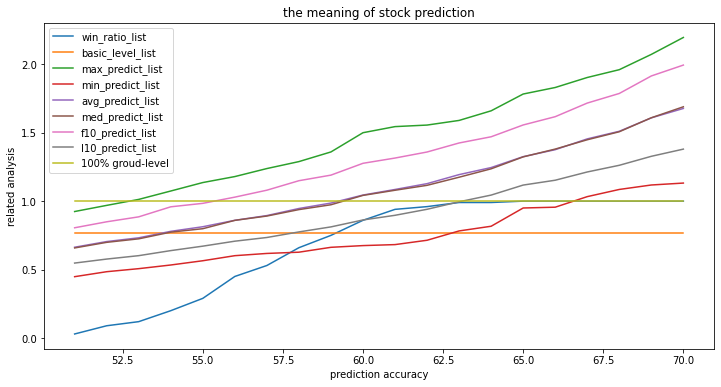

In [33]:
###
def statistical_indicators(tmp_list):
  tmp_list = sorted(tmp_list)
  L = len(tmp_list)
  mx, mn = max(tmp_list), min(tmp_list)
  avg = sum(tmp_list)/len(tmp_list)
  med = tmp_list[L//2]
  last_10 = tmp_list[ int(L*0.1) ]
  first_10 = tmp_list[ int(L*0.9) ]
  return mx, mn, avg, med, first_10, last_10


predict_accuracy_list = []
win_ratio_list = []
basic_level_list = []
max_predict_list = []
min_predict_list = []
avg_predict_list = []
med_predict_list = []
f10_predict_list = []
l10_predict_list = []

for set_year in range(2021, 2022):
  i=set_year
  tn = "0700.HK" # AAPL, AMZN
  st, et = str(i)+"-01-01", str(i)+"-12-31"
  df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
  df_data = get_ymt_date(df_data)
  df_data = calculate_daily_return(df_data)
  df_data = get_market_movement(df_data)
  df_data = df_data.dropna()

  offset_profit = 0.10
  set_accuracy = 0.50
  for ii in range(20):
    set_accuracy += 0.01
    win_loss_list = []
    return_list = []
    for rs in range(200):
      buy_and_hold, profit, detail_operation = prediction_accuracy_meaning(df_data, random_seed=rs, accuracy_ratio=set_accuracy)
      #print( buy_and_hold, profit )
      if profit>buy_and_hold+offset_profit:
        win_loss_list.append(1)
      else:
        win_loss_list.append(0)
      return_list.append( profit )
    win, loss = sum(win_loss_list), len(win_loss_list)-sum(win_loss_list)
    mx, mn, avg, med, first_10, last_10 = statistical_indicators(return_list)
    #max_profit, min_profit, avg_profit = round(max(return_list), 2), round(min(return_list), 2), round(sum(return_list)/len(return_list), 2)
    #print(set_year, "\t", round(set_accuracy*100), "% accuracy \t", win, loss, round(win/(win+loss)*100, 2))
    #print("\t", max_profit, min_profit, avg_profit, round(buy_and_hold, 2))
    #
    predict_accuracy_list.append( round(set_accuracy*100) )
    win_ratio_list.append( round(win/(win+loss), 2) )
    basic_level_list.append( round(buy_and_hold, 2) )
    max_predict_list.append( mx )
    min_predict_list.append( mn )
    avg_predict_list.append( avg )
    med_predict_list.append( med )
    f10_predict_list.append( first_10 )
    l10_predict_list.append( last_10 )
# 
fig = plt.subplots(figsize =(12, 6))
plt.plot(predict_accuracy_list, win_ratio_list, label ='win_ratio_list') # , color ='r'
plt.plot(predict_accuracy_list, basic_level_list, label ='basic_level_list')
plt.plot(predict_accuracy_list, max_predict_list, label ='max_predict_list')
plt.plot(predict_accuracy_list, min_predict_list, label ='min_predict_list')
plt.plot(predict_accuracy_list, avg_predict_list, label ='avg_predict_list')
plt.plot(predict_accuracy_list, med_predict_list, label ='med_predict_list')
plt.plot(predict_accuracy_list, f10_predict_list, label ='f10_predict_list')
plt.plot(predict_accuracy_list, l10_predict_list, label ='l10_predict_list')
plt.plot(predict_accuracy_list, [1]*len(win_ratio_list), label ='100% groud-level')

plt.title("the meaning of stock prediction")
plt.xlabel('prediction accuracy')
plt.ylabel("related analysis")

plt.legend()
plt.show()